# Training an NLP Model to Classify News Category

News Category Dataset is Taken From Kaggle (link below, download the .csv from the website):
https://www.kaggle.com/datasets/1f9e801c614a34d5c4ca204dc8d324e661f9575fe7749177a291efc833aa445f?resource=download

(if you are using our entire .zip file it is already included there)

In this notebook, we will focus on training a news category classifier with the data above.

More emphasis will be given about how we stored the model into a file and then retrieved it for usage in a Web App, how to write the Web App and how to deploy it onto the cloud.

## Exploratory Data Analysis and Pre-processing

First we load in the data and do some basic pre-processing of text.

In [24]:
import pandas as pd

df_raw = pd.read_csv("NewsCategorizer.csv")
df_raw.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


We'll simplify by using just two columns: 'category' and 'short_description'. Essentially, we'll train the model to predict the news category based on its short description.

In [25]:
df = df_raw[['category', 'short_description']]
df.head()

,category,short_description
0,WELLNESS,Resting is part of training. I've confirmed wh...
1,WELLNESS,Think of talking to yourself as a tool to coac...
2,WELLNESS,The clock is ticking for the United States to ...
3,WELLNESS,"If you want to be busy, keep trying to be perf..."
4,WELLNESS,"First, the bad news: Soda bread, corned beef a..."


As can be seen below, there are 10 categories and they equally distributed among the whole dataset.

In [26]:
categories = df['category'].unique()
print(f"Categories: {categories}")
df['category'].value_counts()

Categories: ['WELLNESS' 'POLITICS' 'ENTERTAINMENT' 'TRAVEL' 'STYLE & BEAUTY'
 'PARENTING' 'FOOD & DRINK' 'WORLD NEWS' 'BUSINESS' 'SPORTS']


category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
SPORTS            5000
Name: count, dtype: int64

### Text Cleaning Process

The following code performs a series of text cleaning steps on the `short_description` column:

- Converts text to **lowercase** for consistency.
- Removes **stopwords**, **punctuation**, **single letters**, and **digits** to reduce noise.
- **Trims whitespace** to clean up the text after processing.

These preprocessing steps help prepare the text data for further analysis by simplifying and standardizing the content.

In [27]:
import re
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Define the regex for stopwords and ensure correctness
RE_stopwords = r'\b(?:{})\b'.format('|'.join(re.escape(word) for word in stopwords))  # Escaping stopwords to avoid regex issues

# Apply the transformations
df['short_description'] = (
    df['short_description']
    .str.lower()  # Convert to lowercase
    .str.replace(RE_stopwords, '', regex=True)  # Remove stopwords
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\b[a-zA-Z]\b', '', regex=True)  # Remove single letters
    .str.replace(r'\d+', '', regex=True)  # Remove digits
    .str.strip()  # Trim whitespace
)

C:\Users\ghaza\AppData\Local\Temp\ipykernel_2612\2024340781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_description'] = (


Next, we tokenize the words and apply lemmatization to convert each word to its base form using the NLTK library.

In [28]:
import nltk 

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['short_description'] = df['short_description'].apply(lemmatize_text).str.join(" ")

C:\Users\ghaza\AppData\Local\Temp\ipykernel_2612\875505807.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_description'] = df['short_description'].apply(lemmatize_text).str.join(" ")


Let's explore some examples from the 'WELLNESS' and 'TRAVEL' categories to understand the cleaned data. We'll print the first few rows. Since the text has been processed to remove stopwords, punctuation, and other elements, the sentences may not flow smoothly.

In [29]:
df[df['category']=='WELLNESS']['short_description'].values[:5]

array(['resting part training confirmed sort already knew built running streak built hard workout three five day week lot cross training physical therapy foam rolling also confirmed stubborn',
       'think talking tool coach challenge narrate experience case treat respect may find enjoy company',
       'clock ticking united state find cure team working study dr francisco lopera',
       'want busy keep trying perfect want happy focus making difference',
       'first bad news soda bread corned beef beer highly nutritious meal make luck irish would'],
      dtype=object)

In [30]:
df[df['category']=='TRAVEL']['short_description'].values[:5]

array(['discussion mccandless life either reading book watching film hearing passing information',
       'woke condition turn poke head see could travel horizon contrast thick whiteout slight shadow tent could see blizzard flying past u',
       'traveler going love one',
       'currently live los angeles way new york city two large selffocused metropolitan megacities london london favorite city world far',
       'walked across israel bicycled across burma piloted fishing boat laotian mekong driven land rover across america prove point traveling light trekked around world six week luggage bag kind'],
      dtype=object)

## Visualize How the Words are Distributed in Different Categories

We extract the words from each category and count their occurrences using the Counter() function. Then, we plot the frequency of the 10 most common words for each category. Some words are repeated across categories, such as 'one', 'time', 'year', and 'like'. Ideally, these could be added to the stopwords list, as they appear frequently in all categories. However, the TF-IDF vectorizer we'll use later will handle such words effectively.

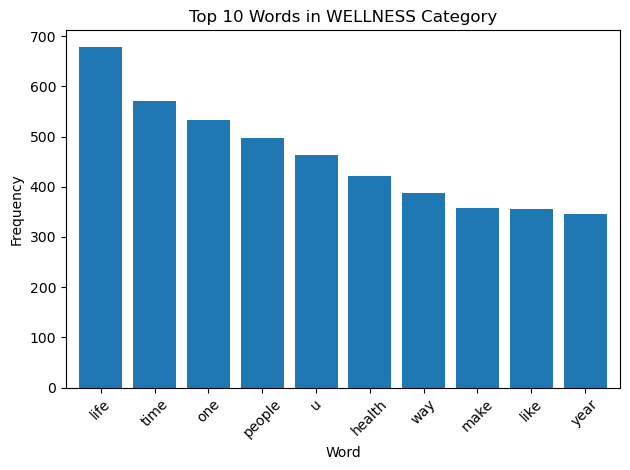

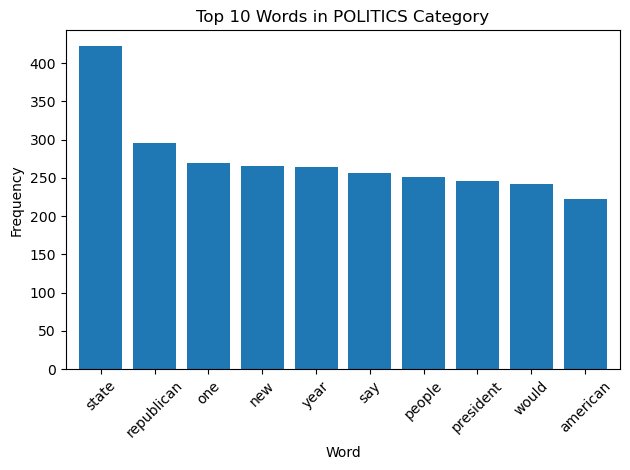

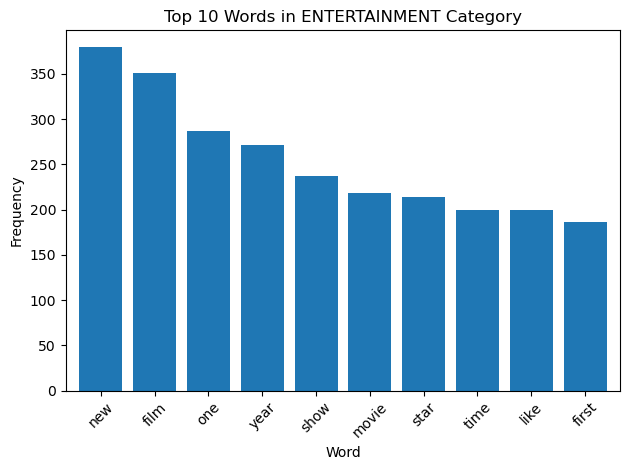

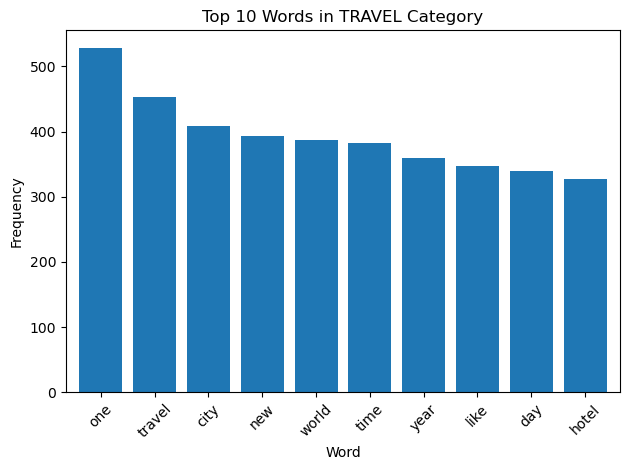

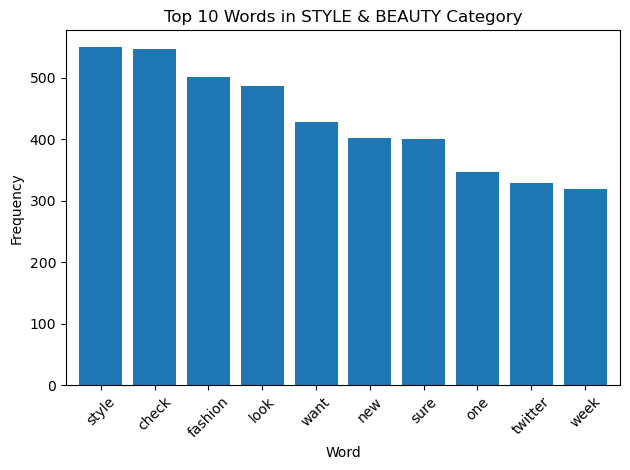

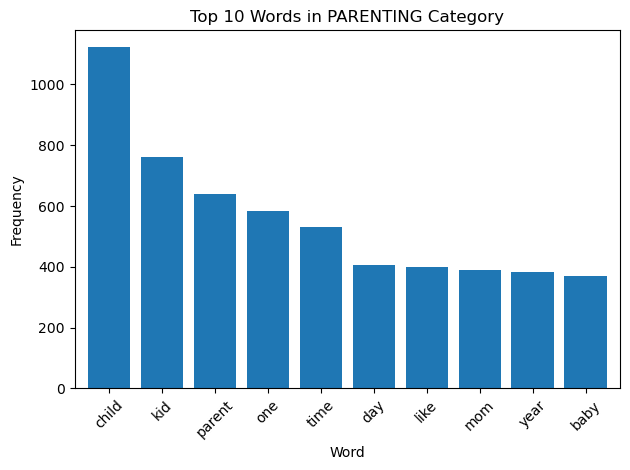

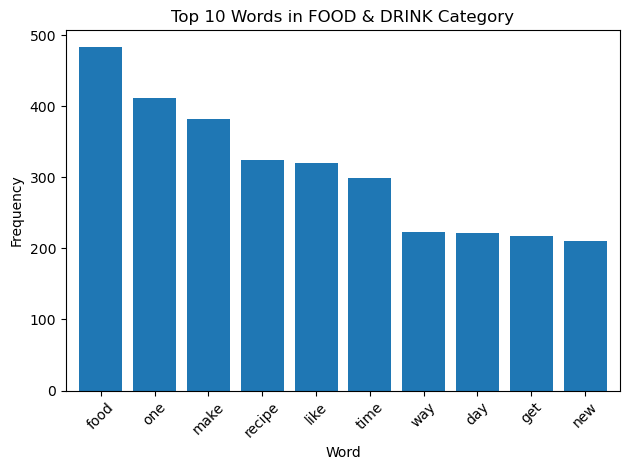

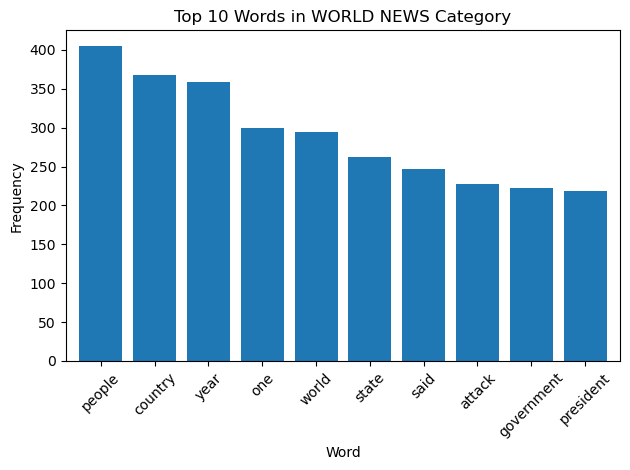

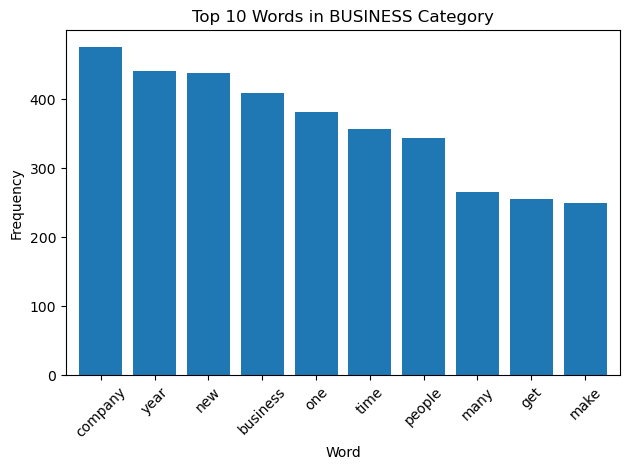

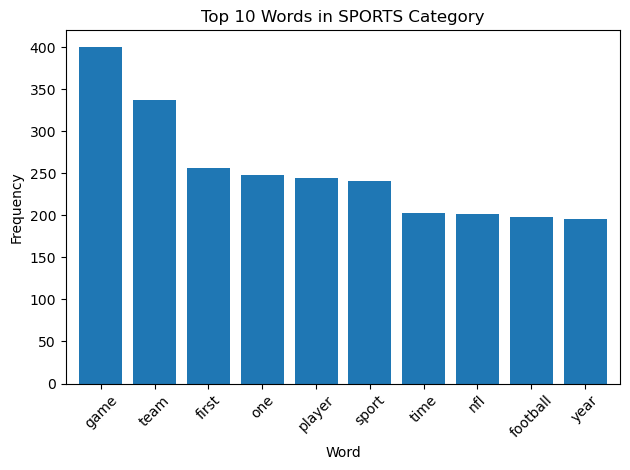

In [31]:
import matplotlib.pyplot as plt
from collections import Counter

top_n = 10  # Number of top words to visualize

for category in categories:
    # Extract words from the 'short_description' column for the current category
    words = df.loc[df['category'] == category, 'short_description'].str.cat(sep=' ').split()

    # Create a DataFrame from the most common words
    word_counts = pd.DataFrame(Counter(words).most_common(top_n), columns=['Word', 'Frequency']).set_index('Word')
    
    # Plot the word frequencies
    word_counts.plot(kind='bar', rot=45, width=0.8, legend=False)
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words in {category} Category')
    plt.tight_layout()
    plt.show()


We have now prepared our text data for training. As usual, the features (text) will be stored in the X variable, while the target (category) will be stored in y.

In [32]:
X = df["short_description"]
y = df["category"]
print(X.head())
print(y.head())

0    resting part training confirmed sort already k...
1    think talking tool coach challenge narrate exp...
2    clock ticking united state find cure team work...
3    want busy keep trying perfect want happy focus...
4    first bad news soda bread corned beef beer hig...
Name: short_description, dtype: object
0    WELLNESS
1    WELLNESS
2    WELLNESS
3    WELLNESS
4    WELLNESS
Name: category, dtype: object


## Split into Train/Test Data and Vectorize the Text with TfidfVectorizer

We need to convert our text into vectors—a meaningful numerical representation—using a vectorizer, as machine learning models work with numbers, not text. Before vectorizing, we split our data into training and testing sets using the train_test_split() function, just like in any machine learning workflow.

### Term Frequency Inverse Document Frequency

We then use a **TfidfVectorizer**, where 'TF-IDF' stands for 'Term Frequency-Inverse Document Frequency'. Essentially, this vectorizer learns all the terms (i.e., words and phrases) present in our text. In this case, we fit it to both single words and two-word phrases using ngram_range=(1, 2). It then converts each text entry in the 'short_description' column into a vector, where each number represents the importance of a term based on its frequency and uniqueness within the dataset.

**'Term Frequency'** means the larger the number, the higher the frequency of the term in the text. 

Importantly, TF-IDF also factors in **Inverse Document Frequency** (IDF). If a term appears frequently across many documents—such as common words like 'one', 'time', or 'year'—it likely has less significance in identifying the category of the text. The IDF component helps by reducing the weight of such common terms. It does so by dividing each term's frequency by the number of documents in which it appears, effectively giving less importance to terms that are not unique. Feel free to explore more about the **TfidfVectorizer** for a deeper understanding.


### Fit on Train Data, Transform both Train and Test Data

The tfidf_vectorizer is fitted *only* on the training data to learn all the relevant terms. We then transform the training data into vectors using the fit_transform() function, which combines both fitting and transformation in one step. After that, we use the same vectorizer to transform the test data into vectors. Importantly, we do not fit the vectorizer on the test data, as the test set simulates unseen user input—similar to how new input will be handled in the future. Later, we will use this fitted tfidf_vectorizer in our web application to transform user-entered text into vectors before making predictions with our trained model.


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split 

# Split the dataset into training and test sets (20% test set, stratified by label distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=False,  # Use raw term frequencies
    min_df=1,            # Include terms with at least 1 occurrence
    norm='l2',           # Use L2 normalization
    encoding='latin-1',  # Encoding of the text
    ngram_range=(1, 2),  # Include unigrams and bigrams
    stop_words=stopwords # Custom stopwords list
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [34]:
# Retrieve and print the last 20 features from the TF-IDF vectorizer
# Note: The features include both single words and two-word phrases (bigrams)
features = tfidf_vectorizer.get_feature_names_out()[-20:]  # Get the last 20 features
features.sort()  # Sort the features alphabetically for easier readability
features

array(['île', 'île de', 'övertorneå', 'övertorneå northern', 'öztürk',
       'öztürk université', 'über', 'über cutie', 'über mom',
       'übertalented', 'übertalented smith', 'łowicz', 'łowicz people',
       'ﬁrst', 'ﬁrst birthday', 'ﬁx', 'ﬁx world', 'ﬁx ﬁx', 'ﬂavors',
       'ﬂavors texture'], dtype=object)

## Train and Fit LinearSVC Model

The accuracy we get here is 70+%, not bad considering it was a very basic Linear Support Vector Classification model without any deep learning involved, and without any tuning of model hyperameters. Also we are only training on the 'short_description' of the news with some very basic pre-processing. Feel free to improve on the model by fine-tuning some of its parameters and do more advanced text pre-processing!

In [35]:
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    hamming_loss,
    cohen_kappa_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import cross_val_score

# Initialize the classifier
svc_classifier = LinearSVC()

# Fit the classifier to the training data
svc_classifier.fit(X_train_tfidf, y_train)

# Create the predicted categories
pred = svc_classifier.predict(X_test_tfidf)

# Accuracy Score
accuracy = metrics.accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Create a DataFrame for better visualization
categories = svc_classifier.classes_ if hasattr(svc_classifier, "classes_") else sorted(set(y_test))
cm_df = pd.DataFrame(cm, index=categories, columns=categories)

# Print the labeled confusion matrix
print("Confusion Matrix:")
print(cm_df)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, pred))

# Precision
precision = precision_score(y_test, pred, average='weighted')  
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, pred, average='weighted')  
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, pred, average='weighted')  
print(f"F1-Score: {f1:.4f}")

# Cross-Validation Accuracy
cv_scores = cross_val_score(svc_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


c:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.7242
Confusion Matrix:
                BUSINESS  ENTERTAINMENT  FOOD & DRINK  PARENTING  POLITICS  \
BUSINESS             414              6             6         13        18   
ENTERTAINMENT         13            295            21         31        21   
FOOD & DRINK           8             17           372         13         8   
PARENTING             10             19            17        346         9   
POLITICS              29             17             7         25       312   
SPORTS                 2             13             5         10         6   
STYLE & BEAUTY         8             28            12         20         7   
TRAVEL                 9             18            27         15         8   
WELLNESS              18             10            20         34         7   
WORLD NEWS            16             14             4         15        40   

                SPORTS  STYLE & BEAUTY  TRAVEL  WELLNESS  WORLD NEWS  
BUSINESS             3             

c:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\svm\_clas

Cross-Validation Accuracy: 0.7126 ± 0.0030


## Test the Model with Some Text

Now comes the fun part—let's test the model with some sample text! We'll create a function that takes an input text, vectorizes it using the transform() method of the tfidf_vectorizer (which was fitted on our training data), and then uses the svc_classifier to predict the news category. Finally, the predicted category will be printed out.

In [36]:
def predict_topic(text):
    result = svc_classifier.predict(tfidf_vectorizer.transform([text]))
    return(result[0])

As a reminder these are the categories involved.

In [37]:
print(f"Categories: {categories}")

Categories: ['BUSINESS' 'ENTERTAINMENT' 'FOOD & DRINK' 'PARENTING' 'POLITICS' 'SPORTS'
 'STYLE & BEAUTY' 'TRAVEL' 'WELLNESS' 'WORLD NEWS']


In [38]:
predict_topic("5 Simple Ways to Improve Your Mental Health Today")

'WELLNESS'

In [39]:
predict_topic("Presidential Debate Sparks Nationwide Conversations")

'POLITICS'

In [40]:
predict_topic("New Marvel Movie Sets Box Office Record")

'ENTERTAINMENT'

In [41]:
predict_topic("Top 10 Destinations to Visit This Summer")

'TRAVEL'

In [42]:
predict_topic("Fall Fashion Trends to Try This Season")

'STYLE & BEAUTY'

## Save the Model and Tfidf Vectorizer for Web App Usage Later

### Pickle library in Python

The pickle library in Python allows us to save Python objects to files on local storage using pickle.dump(). Later, we can load these objects with pickle.load(), making it easy to reuse them across different programs.

In this case, we are saving both the trained svc_classifier model (as 'classifier.pkl') and the tfidf_vectorizer (as 'tfidf_vectorizer.pkl'). These will be loaded in our Flask web application (app.py) to make predictions based on user input.

### Remember to save the tfidf_vectorizer object as well

Why do we need to save the tfidf_vectorizer as well? Recall that the tfidf_vectorizer was fitted only on our training data, meaning it learned the vocabulary from those words and phrases. We then used it to transform both the training and test data. Importantly, we didn't fit it on the test data, as it simulates new, unseen input, and fitting on the test set would invalidate that.

Similarly, in our web application, we'll need the tfidf_vectorizer to transform any new user input into vectors before the svc_classifier can make predictions. This ensures the model works consistently, using the same vocabulary it learned during training.

### Save them to these filepaths

The filepaths of the saved model and vectorizer below are 'news_category_classifier_webapp/model/classifier.pkl' and 'news_category_classifier_webapp/model/tfidf_vectorizer.pkl' If you are using our entire .zip file these files are already saved in these locations.

In [43]:
import pickle 

with open('news_category_classifier_webapp/model/classifier.pkl', 'wb') as file:
    pickle.dump(svc_classifier, file)
    
with open('news_category_classifier_webapp/model/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)